In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn as nn

In [3]:
## une fois le dataset telecharge, mettre download=False !
## Pour le test, train = False
## transform permet de faire un preprocessing des donnees (ici ?)
batch_size=600
nb_digits=10
train_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=True, download=True, shuffle = True,
                                                          transform=transforms.Compose([transforms.ToTensor(),
                                                                                        transforms.Normalize((0.1307,),(0.3081,))])),
                                                           batch_size=batch_size) 
test_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=False, download=True, 
                                                          transform=transforms.Compose([transforms.ToTensor(),
                                                                                        transforms.Normalize((0.1307,),(0.3081,))])),
                                                           batch_size=batch_size) 



In [4]:
y_onehot = torch.FloatTensor(batch_size, nb_digits) 

for i,(data,target) in enumerate(train_loader):
    #print(i,data.size(),data.type(),target.size(),target.type())
    # do something...
    X = data
    ## Encoding des labels en onehot
    y_onehot.zero_()
    y_onehot.scatter_(1, target.view(-1,1), 1)
    break


In [5]:
X.shape

torch.Size([600, 1, 28, 28])

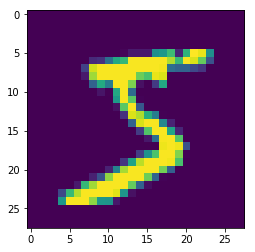

In [6]:
plt.imshow(X[0][0])

In [7]:
target

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
        1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5,
        9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0, 4, 5, 6, 1, 0, 0, 1, 7,
        1, 6, 3, 0, 2, 1, 1, 7, 9, 0, 2, 6, 7, 8, 3, 9, 0, 4, 6, 7, 4, 6, 8, 0,
        7, 8, 3, 1, 5, 7, 1, 7, 1, 1, 6, 3, 0, 2, 9, 3, 1, 1, 0, 4, 9, 2, 0, 0,
        2, 0, 2, 7, 1, 8, 6, 4, 1, 6, 3, 4, 5, 9, 1, 3, 3, 8, 5, 4, 7, 7, 4, 2,
        8, 5, 8, 6, 7, 3, 4, 6, 1, 9, 9, 6, 0, 3, 7, 2, 8, 2, 9, 4, 4, 6, 4, 9,
        7, 0, 9, 2, 9, 5, 1, 5, 9, 1, 2, 3, 2, 3, 5, 9, 1, 7, 6, 2, 8, 2, 2, 5,
        0, 7, 4, 9, 7, 8, 3, 2, 1, 1, 8, 3, 6, 1, 0, 3, 1, 0, 0, 1, 7, 2, 7, 3,
        0, 4, 6, 5, 2, 6, 4, 7, 1, 8, 9, 9, 3, 0, 7, 1, 0, 2, 0, 3, 5, 4, 6, 5,
        8, 6, 3, 7, 5, 8, 0, 9, 1, 0, 3, 1, 2, 2, 3, 3, 6, 4, 7, 5, 0, 6, 2, 7,
        9, 8, 5, 9, 2, 1, 1, 4, 4, 5, 6, 4, 1, 2, 5, 3, 9, 3, 9, 0, 5, 9, 6, 5,
        7, 4, 1, 3, 4, 0, 4, 8, 0, 4, 3,

In [8]:
class ConvNet1(nn.Module):
    
    def __init__(self):
        super(ConvNet1, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 3, kernel_size=3, stride=1),
        )
        self.tret = nn.Sequential(
            nn.ReLU(),
            nn.MaxPool2d(3, stride=3)
        )
        self.clas = nn.Sequential(
            nn.Linear(24, 10),
            #nn.ReLU(),
            #nn.Linear(100, 3)
        )
    
    def forward(self, X):
        out = self.conv1(X)
        out = self.tret(out)
        out = out.mean(dim=len(out.shape)-1)
        out = out.view(X.shape[0], -1)
        out = self.clas(out)
        return out
    
    def score(self,ypred,y):
        score = 0
        if len(y) != len(ypred):
            print('ERREUR')
        for i in range(0,len(y)):
            if y[i] == ypred[i].argmax():
                score += 1
        return(score/len(y))

A lire (mémo pour juliette):
* https://hackernoon.com/visualizing-parts-of-convolutional-neural-networks-using-keras-and-cats-5cc01b214e59
* https://jacobgil.github.io/deeplearning/filter-visualizations
* https://www.quora.com/What-are-good-ways-to-visualize-filters-in-convolution-neural-network
* https://www.youtube.com/watch?v=cNBBNAxC8l4
* http://setosa.io/ev/image-kernels/
* https://ludo-louis.fr/differents-types-reseaux-neurones-reseau-convolution/


In [9]:
model = ConvNet1()
loss = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

train_loss = []
test_loss = []

train_score = []
test_score = []


### Train
#--------------------------------------------------------
for k in range(10):
    print(k)
    ####### TRAIN #######
    costs_train = []
    scores_train = []
    costs_test = []
    scores_test = []
    for i,(x,target) in enumerate(train_loader):

        ## Encoding des labels en onehot
        out = model(x)
        cost = loss(out, target)
        optim.zero_grad()
        cost.backward()
        optim.step()
        costs_train.append(cost)
        scores_train.append(model.score(out, target))
        
        train_loss.append(torch.tensor(costs_train).mean())
        train_score.append(torch.tensor(scores_train).mean())
        
    for i,(x,target) in enumerate(test_loader):
        ## Encoding des labels en onehot
        out = model(x)
        cost = loss(out, target)
        optim.zero_grad()
        cost.backward()
        optim.step()
        costs_test.append(cost)
        scores_test.append(model.score(out, target))

        test_loss.append(torch.tensor(costs_test).mean())
        test_score.append(torch.tensor(scores_test).mean())


0
1
2
3
4
5
6
7
8
9


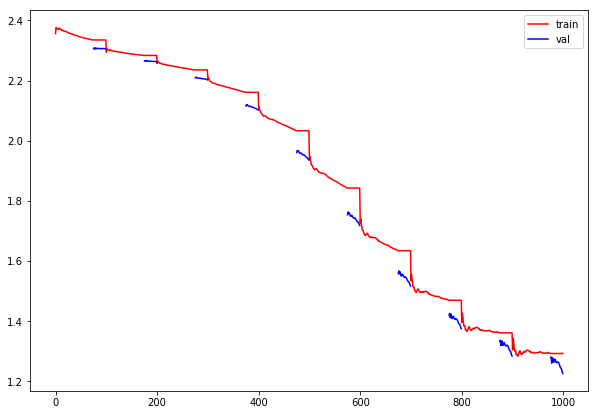

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
plt.plot(train_loss, c="red", label="train")
plt.plot(test_loss, c="b", label="val")
plt.legend(loc="best")
plt.show()

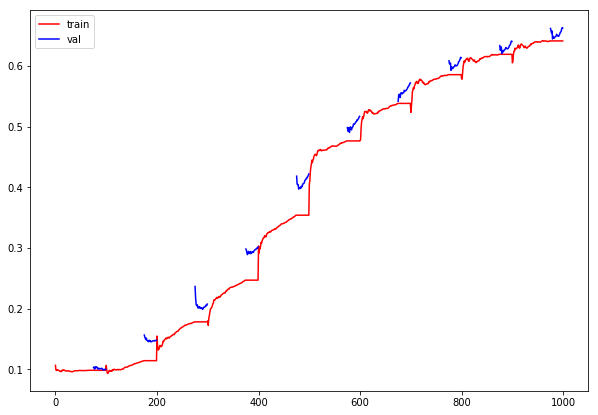

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
plt.plot(train_score, c="red", label="train")
plt.plot(test_score, c="b", label="val")
plt.legend(loc="best")
plt.show()

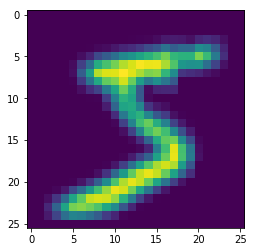

In [12]:
plt.imshow(model.conv1(X).detach().numpy()[0][0])

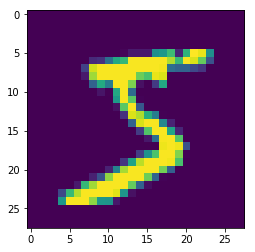

In [13]:
plt.imshow(X[0][0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


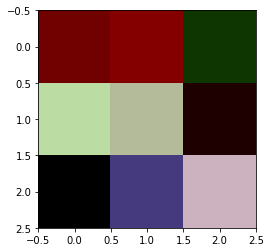

In [26]:
plt.imshow(model.conv1[0].weight.detach().numpy().reshape(3,3,3))

In [17]:
model.conv1[0].weight.detach().numpy().reshape(3,3,3)

array([[[ 0.91224855,  0.65296507,  0.65383154],
        [ 0.81507355,  0.46184105,  0.7498535 ],
        [ 0.4237806 ,  0.19310461,  0.05846434]],

       [[-0.1986126 ,  0.38360152,  0.16965137],
        [ 0.08436508,  0.36630067,  0.2716776 ],
        [ 0.16040513,  0.3709798 , -0.00348697]],

       [[-0.29775566,  0.24726701, -0.0108733 ],
        [ 0.4201758 ,  0.23964223,  0.50734675],
        [ 0.44951648, -0.12333789,  0.29828176]]], dtype=float32)